# Funções

In [2]:
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import pandas as pd
import control as ct
import scipy as sp

def obter_sistema(zeta=None, wn=None, k=None, num=None, den=None):
    if num is not None and den is not None:
        sc_tf = ct.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    elif zeta is not None and wn is not None and k is not None:
        num = [k*wn**2]
        den = [1, 2*zeta*wn, wn**2]
        sc_tf = signal.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer os coeficientes da função de segunda ordem ou os coeficientes num e den.")

    gm, pm, wg, wp = ct.margin(ct_tf)
    df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    df.loc['Sistema'] = [gm, pm, wg, wp]
    print(ct_tf)
    print("Polos:", ct_tf.pole())
    print("Zeros:", ct_tf.zero())
    return sc_tf, ct_tf, df

def obter_compensador(alpha, T, kc):
    
    num = [kc*T, kc*1]
    den = [alpha * T, 1]
    sc_tf = signal.TransferFunction(num, den)
    ct_tf = ct.TransferFunction(num, den)
    gm, pm, wg, wp = ct.margin(ct_tf)

    df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    if alpha > 1:   df.loc['Compensador de atraso'] = [gm, pm, wg, wp]
    elif alpha < 1: df.loc['Compensador de avanço'] = [gm, pm, wg, wp]
    else:           df.loc['Não é compensador'] = [gm, pm, wg, wp]
    print(ct_tf)
    print("Polos:", ct_tf.pole())
    print("Zeros:", ct_tf.zero())

    return sc_tf, ct_tf, df

def obter_parametros_funcao(num=None, den=None, sys=None):
    if sys is not None:
        sistema = sys
    elif num is not None and den is not None:
        sistema = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer o sistema ou o numerador e o denominador.")
    info_sistema = ct.step_info(sistema)
    df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
    df_sistema.index.name = 'Parâmetro'
    df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
    e_ss_atual = float(f"{1 / float(df_sistema.at['SteadyStateValue', 'Valor']):.4f}")
    df_adicional = pd.DataFrame({'Valor': [e_ss_atual]}, index=['Erro(%)'])
    df_sistema = pd.concat([df_sistema, df_adicional])
    # df_sistema = df_sistema.drop(['SettlingMin', 'SettlingMax', 'Undershoot'])
    return df_sistema

def calcular_bode(sistema, criterio, valor, resolucao):

    w = np.logspace(-2, 3, num=resolucao)  # Definir o array de frequências com mais pontos
    omega, mag, phase = signal.bode(sistema, w=w)   # produz a simulação de Bode

    # verifica qual critério o usuário escolheu e retorna o valores com base nele
    if criterio == "frequencia":
        indice = np.argmin(np.abs(omega - valor))
    elif criterio == "fase":
        valor_rad = np.deg2rad(valor)
        indice = np.argmin(np.abs(phase - valor))
    elif criterio == "ganho":
        indice = np.argmin(np.abs(mag - valor))
    frequencia = omega[indice]
    fase = phase[indice]
    ganho = mag[indice]

    # produz uma tabela (Dataframe) para melhor visualização dos resultados
    df = pd.DataFrame({"Frequência (rad/s)": [frequencia],"Fase (graus)": [fase],"Ganho (dB)": [ganho]}, index=["valores"])

    return df

def plot_bode_multiple(transfer_functions):
    
    # Frequências para o cálculo do Bode
    w = np.logspace(-2, 4, num=1000)

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    for name, transfer_function in transfer_functions.items():

        # Obter os dados do diagrama de Bode
        omega, mag, phase = signal.bode(transfer_function,w=w)

        # Plot do diagrama de ganho
        ax1.semilogx(omega, mag, label=name)

        # Plot do diagrama de fase
        ax2.semilogx(omega, phase, label=name)

        # 20*np.log10(mag)
        # phase*(180/np.pi)

    ax1.set_xlabel('Frequência (rad/s)')
    ax1.set_ylabel('Ganho (dB)')
    ax1.set_title('Diagrama de Bode - Ganho')
    ax1.grid(True, which='both', linestyle='dotted')
    ax1.legend()

    ax2.set_xlabel('Frequência (rad/s)')
    ax2.set_ylabel('Fase (graus)')
    ax2.set_title('Diagrama de Bode - Fase')
    ax2.grid(True, which='both', linestyle='dotted')
    ax2.legend()

    # Retorna a figura
    # return fig

def multiplica_funcoes_transferencia(tf1, tf2):
    num = np.convolve(tf1.num, tf2.num)
    den = np.convolve(tf1.den, tf2.den)
    tf_mult = signal.TransferFunction(num, den)
    return tf_mult



# QUESTÃO 1

### polos

In [112]:
import control

# parâmetros calculados
zeta = 0.3346
wn = 4.4971
k = 1.3885

# definindo a função transferência
num = [k*wn**2]
den = [1, 2*zeta*wn, wn**2]

sys = control.TransferFunction(num, den)  # Criação do sistema

zeros = control.zero(sys)  # Cálculo dos zeros
polos = control.pole(sys)  # Cálculo dos polos

print("Zeros:", zeros)
print("Polos:", polos)

Zeros: []
Polos: [-1.50472966+4.23788828j -1.50472966-4.23788828j]


### Simulação de bode

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# parâmetros calculados
zeta = 0.3346
wn = 4.4971
k = 1.3885

# definindo a função transferência
num = [k*wn**2]
den = [1, 2*zeta*wn, wn**2]

sys = control.TransferFunction(num, den)  # Criação do sistema

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(8, 6))

# Obter os dados do diagrama de Bode
mag, phase, omega = control.bode(sys, dB=True, Hz=False, omega_limits=(1e-2, 1e3))

# Plotar o gráfico manualmente usando o objeto ax
ax.semilogx(omega, mag)
ax.set_xlabel('Frequência (Hz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Diagrama de Bode')


plt.show()

print("→ Informações obtidas numéricamente:")

# Cálculo das margens de fase e ganho
gm, pm, wgc, wpc = control.margin(sys)

# Imprimir as informações em um dataframe
data = {'Margem de Ganho (dB)': [20 * np.log10(gm)],
        'Margem de Fase (graus)': [pm],
        'Frequência de Crossover (\u03C9/seg)': [wgc],
        'Frequência de Fase Zero (\u03C9/seg)': [wpc]}

df = pd.DataFrame(data)
df

### simulação de nyquist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# parâmetros calculados
zeta = 0.3346
wn = 4.4971
k = 1.3885

# definindo a função transferência
num = [k*wn**2]
den = [1, 2*zeta*wn, wn**2]

sys = control.TransferFunction(num, den)  # Criação do sistema

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(8, 6))

# Plotar o diagrama de Nyquist
ct.nyquist(sys)

# Configurar os rótulos e título do gráfico
ax.set_xlabel('Real')
ax.set_ylabel('Imaginário')
ax.set_title('Diagrama de Nyquist')

# Definir limites para o eixo y
ax.set_ylim(-3, 0.5)  # Ajuste os valores de limite conforme necessário

# Configurar o aspecto igual para fazer o gráfico proporcional
ax.set_aspect('equal')

plt.show()


# QUESTÃO 2 

### simulação de diversos ganhos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# parâmetros calculados
zeta = 0.3346
wn = 4.4971
k = 1.3885

# definindo a função transferência
num = [k*wn**2]
den = [1, 2*zeta*wn, wn**2]

# Valores diferentes de k
k_values = [1, 10, 100]

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(12, 10))

# Loop pelos valores de k
for k in k_values:
    # Criar a função de transferência com o valor de k atual
    sys = ct.TransferFunction(k * np.array(num), den)
    
    # Plotar o diagrama de Nyquist para o valor de k atual
    ct.nyquist(sys)

# Configurar os rótulos e título do gráfico
ax.set_xlabel('Real')
ax.set_ylabel('Imaginário')
ax.set_title('Diagrama de Nyquist')

# Ajustar os limites dos eixos x e y para enfatizar a parte em torno de -1
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 0.5])

# Configurar o aspecto igual para fazer o gráfico proporcional
ax.set_aspect('equal')

plt.show()


# QUESTÃO 3 

### obtenção da tabela

In [ ]:
# Médias, valores máximos e variação máxima do dados 'a5.csv'

data_dict={'Sobressinal': {'Média': 0.33011062039602557, 
                           'Valor Máximo': 0.39442231075697215, 
                           'Variação Máxima': 0.06431169036094658}, 
            'Coeficiente de Amortecimento (ζ)': {'Média': 0.33455454545454544, 
                                                 'Valor Máximo': 0.4029, 
                                                 'Variação Máxima': 0.06834545454545454}, 
            'Frequência Natural não Amortecida (ω_d)': {'Média': 4.778245454545455, 
                                                        'Valor Máximo': 7.4458, 
                                                        'Variação Máxima': 2.6675545454545455}, 
            'Frequência Natural Amortecida (ω_n)': {'Média': 4.497063636363636, 
                                                    'Valor Máximo': 6.9813, 
                                                    'Variação Máxima': 2.484236363636364}, 
            'Ganho': {'Média': 1.3885018106236868,
                      'Valor Máximo': 2.3224299065420557, 
                      'Variação Máxima': 0.9339280959183689}}
df_medias_copiado = pd.DataFrame(data_dict)
df_medias_copiado

### variação do ganho 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# Parâmetros calculados
zeta = 0.3346
wn = 4.4971

# Nossos valores de ganho a serem observados
k_values = [1.3885, 2.3224]

# Criar uma nova figura com tamanho personalizado
fig, axs = plt.subplots(len(k_values), 1, figsize=(10, 6*len(k_values)))

for i, k in enumerate(k_values):
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = control.TransferFunction(num, den)
    
    # Obter os dados do diagrama de Bode
    mag, phase, omega = control.bode(sys, dB=True, Hz=False, omega_limits=(1e-2, 1e3))
    
    # Plotar o gráfico manualmente usando o objeto ax correspondente
    ax = axs[i]
    ax.semilogx(omega, mag)
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(f'Diagrama de Bode para k = {k}')

plt.tight_layout()
plt.show()

print("→ Informações obtidas numericamente:")

# Cálculo das margens de fase e ganho para o último valor de k
gm, pm, wgc, wpc = control.margin(sys)

# Imprimir as informações em um dataframe
data = {'Margem de Ganho (dB)': [20 * np.log10(gm)],
        'Margem de Fase (graus)': [pm],
        'Frequência de Crossover (Ω/seg)': [wgc],
        'Frequência de Fase Zero (Ω/seg)': [wpc]}

df = pd.DataFrame(data)
df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Parâmetros calculados
zeta = 0.3346
wn = 4.4971

# Nossos valores de ganho a serem observados
k_values = [1.3885, 2.3224]

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(10, 6))

for k in k_values:
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)
    
    # Plotar o diagrama de Nyquist para o valor de k atual
    ct.nyquist(sys)
    
# Configurar os rótulos e título do gráfico
ax.set_xlabel('Real')
ax.set_ylabel('Imaginário')
ax.set_title('Diagrama de Nyquist')

# Definir limites para o eixo y
ax.set_ylim(-3, 0.5)  # Ajuste os valores de limite conforme necessário

# Configurar o aspecto igual para fazer o gráfico proporcional
ax.set_aspect('equal')

plt.show()


### variação do coeficiente de amortecimento

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# Parâmetros calculados
wn = 4.4971
k = 1.3885

# Nossos valores de ganho a serem observados
zeta_values= [0.3346, 0.4029]

# Criar uma nova figura com tamanho personalizado
fig, axs = plt.subplots(len(zeta_values), 1, figsize=(10, 6*len(zeta_values)))

for i, zeta in enumerate(zeta_values):
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = control.TransferFunction(num, den)
    
    # Obter os dados do diagrama de Bode
    mag, phase, omega = control.bode(sys, dB=True, Hz=False, omega_limits=(1e-2, 1e3))
    
    # Plotar o gráfico manualmente usando o objeto ax correspondente
    ax = axs[i]
    ax.semilogx(omega, mag)
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(f'Diagrama de Bode para k = {k}')

plt.tight_layout()
plt.show()

print("→ Informações obtidas numericamente:")

# Cálculo das margens de fase e ganho para o último valor de k
gm, pm, wgc, wpc = control.margin(sys)

# Imprimir as informações em um dataframe
data = {'Margem de Ganho (dB)': [20 * np.log10(gm)],
        'Margem de Fase (graus)': [pm],
        'Frequência de Crossover (Ω/seg)': [wgc],
        'Frequência de Fase Zero (Ω/seg)': [wpc]}

df = pd.DataFrame(data)
df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Parâmetros calculados
wn = 4.4971
k = 1.3885

# Nossos valores de ganho a serem observados
zeta_values= [0.3346, 0.4029]

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(10, 6))

for zeta in zeta_values:
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)
    
    # Plotar o diagrama de Nyquist para o valor de k atual
    ct.nyquist(sys)
    
# Configurar os rótulos e título do gráfico
ax.set_xlabel('Real')
ax.set_ylabel('Imaginário')
ax.set_title('Diagrama de Nyquist')

# Definir limites para o eixo y
ax.set_ylim(-3, 0.5)  # Ajuste os valores de limite conforme necessário

# Configurar o aspecto igual para fazer o gráfico proporcional
ax.set_aspect('equal')

plt.show()


### variação da frequencia amortecida

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control
import pandas as pd

# Parâmetros calculados
k = 1.3885
zeta = 0.3346

# Nossos valores de ganho a serem observados
wn_values = [4.4971, 6.9813]

# Criar uma nova figura com tamanho personalizado
fig, axs = plt.subplots(len(wn_values), 1, figsize=(10, 6*len(wn_values)))

for i, zeta in enumerate(wn_values):
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = control.TransferFunction(num, den)
    
    # Obter os dados do diagrama de Bode
    mag, phase, omega = control.bode(sys, dB=True, Hz=False, omega_limits=(1e-2, 1e3))
    
    # Plotar o gráfico manualmente usando o objeto ax correspondente
    ax = axs[i]
    ax.semilogx(omega, mag)
    ax.set_xlabel('Frequência (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(f'Diagrama de Bode para k = {k}')

plt.tight_layout()
plt.show()

print("→ Informações obtidas numericamente:")

# Cálculo das margens de fase e ganho para o último valor de k
gm, pm, wgc, wpc = control.margin(sys)

# Imprimir as informações em um dataframe
data = {'Margem de Ganho (dB)': [20 * np.log10(gm)],
        'Margem de Fase (graus)': [pm],
        'Frequência de Crossover (Ω/seg)': [wgc],
        'Frequência de Fase Zero (Ω/seg)': [wpc]}

df = pd.DataFrame(data)
df

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# Parâmetros calculados
k = 1.3885
zeta = 0.3346

# Nossos valores de ganho a serem observados
wn_values = [4.4971, 6.9813]

# Criar uma nova figura com tamanho personalizado
fig, ax = plt.subplots(figsize=(10, 6))

for wm in wn_values:
    # Definir a função de transferência com o valor de k atual
    num = [k*wn**2]
    den = [1, 2*zeta*wn, wn**2]
    sys = ct.TransferFunction(num, den)
    
    # Plotar o diagrama de Nyquist para o valor de k atual
    ct.nyquist(sys)
    
# Configurar os rótulos e título do gráfico
ax.set_xlabel('Real')
ax.set_ylabel('Imaginário')
ax.set_title('Diagrama de Nyquist')

# Definir limites para o eixo y
ax.set_ylim(-3, 0.5)  # Ajuste os valores de limite conforme necessário

# Configurar o aspecto igual para fazer o gráfico proporcional
ax.set_aspect('equal')

plt.show()


# QUESTÃO 4.a

## <font style='font-size: 20px;'> O sistema tal como é  </font> <hr style='line: 2px solid;'>

Aqui vamos somente reproduzir a função e obter algumas informações 
inclundo o erro no estado estacionário.

In [3]:
sistema_sc, sistema_ct, df_sistema = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)
df_sistema


        28.08
---------------------
s^2 + 3.009 s + 20.22

Polos: [-1.50472966+4.23788828j -1.50472966-4.23788828j]
Zeros: []


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,43.14319,NaN,6.380678


A primeira coisa que iremos fazer é resolver nosso requisito de erro no estado estacionário. Abaixo, vamos obter algumas informações sobre nosso sistema.

In [4]:
obter_parametros_funcao(sys=sistema_ct)

,Valor
RiseTime,0.2782
SettlingTime,2.5040
SettlingMin,1.2393
SettlingMax,1.8436
Overshoot,32.7759
Undershoot,0.0000
Peak,1.8436
PeakTime,0.7419
SteadyStateValue,1.3885
Erro(%),0.7202


## <font style='font-size: 20px;'> Garantido erro estacionário com ganho adequado </font> <hr style='line: 2px solid;'>

O erro estacionário ao degrau é proporcional a uma constante $K_p$, em sistemas do tipo 0 — que é o caso. Logo:

$$e_{ss} = \frac{1}{1+K_p} → K_p = 49$$

O que acabamos de encontrar foi um *controlador proporcional*, a razão ganho natural do sistema pelo *ganho de posição*, $\frac{K}{K_p}$, produz um erro muito próximo à 0.02. Este tipo de controlador, entretanto, não consegue sintonizar corretamente a margem de fase. Por isso vamos projetar o *compensador* para tentar sintonizar, também, o requisito de margem de fase. Compensadores tem a seguinte forma:

$$ C(s) = K_c \frac{Ts+1}{\alpha Ts+1}$$

- se $\alpha < 1$, você está adicionando um *compensador de avanço de fase*;
- se $0 <\alpha < 1$, você está adicionando um *compensador de atraso de fase*;
- se $\alpha = 1$, você está adicionando um *controlador proporcional*;
- se $\alpha = 0$, você está adicionando um *zero + controlador proporcional*;

Para projetar um compensador de avanço, a primeira coisa a se fazer é determinar qual será o ganho. Isso se faz dividindo o ganho natural do sistema em malha aberta pelo ganho proporcional para o requisito de erro estacionário:

$$ K_c = \frac{K}{K_p} → \frac{1.3885}{49} → \boxed{K_c = 35.2899} $$

Com isso, temos o ganho do nosso compensador.

## <font style='font-size: 20px;'> Definição dos parâmetros baseado na fase necessária </font> <hr style='line: 2px solid;'>

Na prática, o que fazemos é olhar para o nosso instrumento de análise, o *Diagrama de Bode* — preferível ao *Plot de Nyquist* por ser uma superposição gráfica dos elementos que compõe o sistema. Aqui, vamos usar cálculo numérico para isso (os plots só virão ao fim dos cálculos) para encontrar nossos valores. 

A função python 'calcula_bode' nos dá três critérios:

- 'frequencia' : retorna frequência, ganho e fase para o valor de frequêcia que você forneceu;
- 'ganho' : retorna frequência, ganho e fase para o valor de ganho que você forneceu;
- 'fase' : retorna frequência, ganho e fase para o valor de fase que você forneceu;

>  As unidades retornadas são $rad/s$, $dB$ e $graus$. Quanto maior a 'resolucao', maior será a precisão dos valores retornados.



In [5]:
calcular_bode(sistema_sc, criterio="fase", valor=-117, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,5.342293,-117.350678,3.81422


Na literatura (*Ogata, 5°Ed, figura 7.91*), podemos ver que o diagrama polar desse tipo de compensador fornece duas relações interessantes para cálculo, a saber:

$\phi_m$, fase máxima:
$$ \sin{\phi_m} = \frac{1-\alpha}{1+\alpha} $$

$\omega_m$, ganho máxima:
$$ |C(j\omega_m)| = \frac{1}{\sqrt{\alpha}} $$

Considerando nosso requisito de fase, $55°+5°-43°=17°$, precisamos que $\phi_m=17°$. Logo temos:

$$ 0.2923 = \frac{1-\alpha}{1+\alpha} → \boxed{\alpha = 0.5476} $$

Agora, podemos calcular também o máximo de ganho que nosso compensador pode fornecer:

$$ |C(j\omega_m)| = \frac{1}{\sqrt{0.5476}} →  \boxed{|C(j\omega_m)| = 1.8261 dB}$$

Então, o que queremos é que o modulo do sistema, $|G(j\omega)| = -6,2 dB$, e vamos buscar a frequência para esse ganho.

In [6]:
calcular_bode(sistema_sc, criterio='ganho', valor=-6.2, resolucao=1000)

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,8.470868,-153.678397,-6.224015


Ou seja, nossa nova frequência de corte será $8.4 rad/s$, pois se o cruzamento for $\omega_m$, o ganho do compesador vai zerar com o ganho do sistema. Para garantir isso, precisamos encontrar o $T$ que faça isso, assim:

$$\omega_m = \frac{1}{\sqrt{\alpha}T} → \boxed{T = 0.1595}$$

Logo nosso compensador será:

In [7]:
compensador_avanco_sc, compensador_avanco_ct, df_compensador_avanco = obter_compensador(alpha=0.5476, T=0.1595, kc=35.2899)
df_compensador_avanco


5.629 s + 35.29
---------------
 0.08734 s + 1

Polos: [-11.44921928+0.j]
Zeros: [-6.26959248+0.j]


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Compensador de avanço,inf,inf,NaN,NaN


## <font style='font-size: 20px;'> Simulação e plot </font> <hr style='line: 2px solid;'>

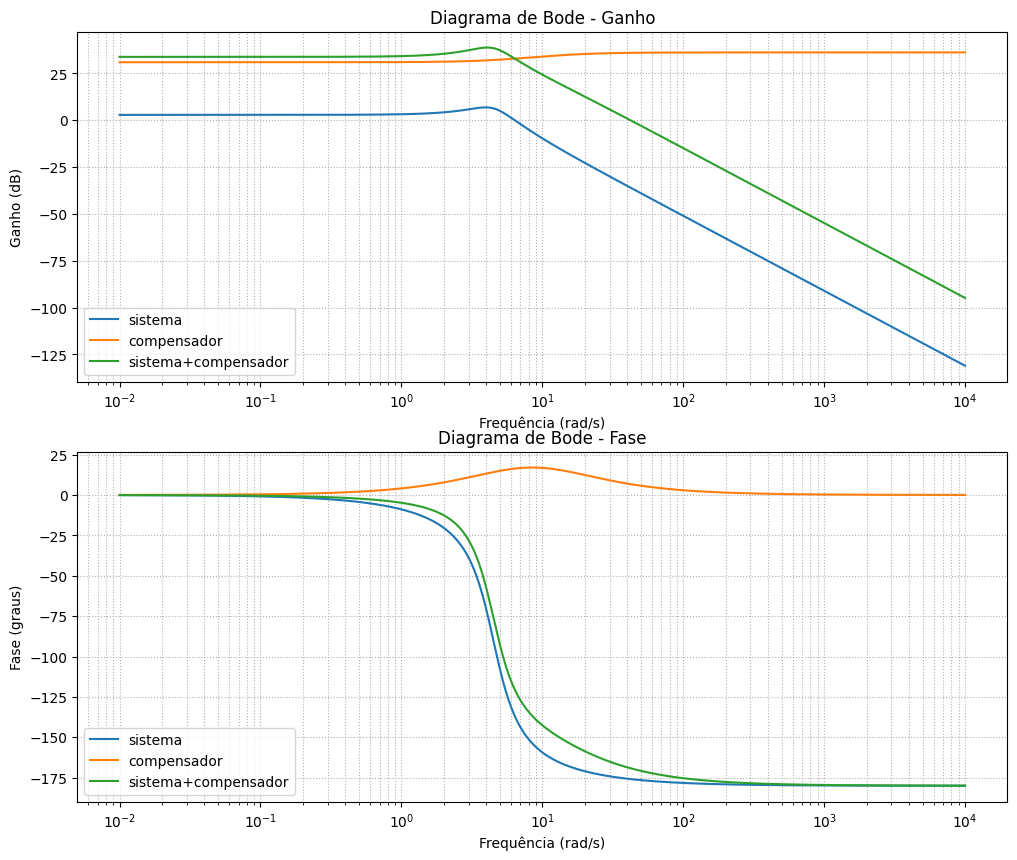

In [8]:
malha_aberta_sc = multiplica_funcoes_transferencia(sistema_sc, compensador_avanco_sc)
plot_bode_multiple({'sistema':sistema_sc, 'compensador':compensador_avanco_sc, 'sistema+compensador':malha_aberta_sc})

In [9]:
malha_aberta_ct = sistema_ct*compensador_avanco_ct
print(malha_aberta_ct)


              158.1 s + 991
-----------------------------------------
0.08734 s^3 + 1.263 s^2 + 4.776 s + 20.22



In [10]:
malha_aberta_sc, malha_aberta_ct, df_malha_aberta = obter_sistema(num=[158.1, 991], den=[0.0873, 1.263, 4.776, 20.22])
df_malha_aberta


             158.1 s + 991
----------------------------------------
0.0873 s^3 + 1.263 s^2 + 4.776 s + 20.22

Polos: [-11.45678034+0.j          -1.5052868 +4.23680715j
  -1.5052868 -4.23680715j]
Zeros: [-6.26818469+0.j]


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Sistema,inf,10.862541,NaN,42.220691


In [11]:
obter_parametros_funcao(sys=malha_aberta_ct)

,Valor
RiseTime,0.2650
SettlingTime,2.4330
SettlingMin,42.6554
SettlingMax,68.4190
Overshoot,39.5996
Undershoot,0.0000
Peak,68.4190
PeakTime,0.6625
SteadyStateValue,49.0109
Erro(%),0.0204


In [12]:
malha_fechada = ct.feedback(sistema_ct, compensador_avanco_ct)
print(malha_fechada)
print(f"Zeros:{ct.zero(malha_fechada)}")
print(f"Polos:{ct.pole(malha_fechada)}")
obter_parametros_funcao(sys=malha_fechada)



            2.453 s + 28.08
----------------------------------------
0.08734 s^3 + 1.263 s^2 + 162.8 s + 1011

Zeros:[-11.44921928+0.j]
Polos:[-4.03608523+42.38515029j -4.03608523-42.38515029j
 -6.38650814 +0.j        ]


,Valor
RiseTime,0.0413
SettlingTime,0.7672
SettlingMin,0.0145
SettlingMax,0.0317
Overshoot,14.2017
Undershoot,0.0000
Peak,0.0317
PeakTime,0.0767
SteadyStateValue,0.0278
Erro(%),35.9712


# QUESTÃO 4.b

Como vimos ... Esse tipo de controlador é interessante quando já temos o ganho ajustado ao erro e só queremos garantir a margem de fase. Na prática, vamos atrasar a fase para que a frequência de corte ocorra no início da transitório original. No código abaixo, vamos gerar nossos sitema novamente e obter suas margens.

Se você subtrair: $-180° + MF = \theta$. 

$\theta$ será a fase onde você terá sua margem de fase desejada. A partir dela você pode encontrar qual deve ser sua frequência de corte. No nosso caso, $-180°+55°=-125°$ e acrescentaremos 8° por recomendação da literatura.

In [8]:
df_bode = calcular_bode(sistema, criterio="fase", valor=-117, resolucao=1000)
df_bode

,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,5.342293,-117.350678,3.81422


No caso, a função 'calcular_bode_dataframe' retorna os valores de frequência, fase e Ganho. Mas de todo o caso, o que se faz é observar gráfico e traçar uma linha para a' margem de fase que precisa, identificando com isso, onde o ganho que precisaria estar para produzir essa margem de fase. Com isso você pode calcular a queda de ganho necessária.

No nosso caso, a frequência está por volta de $5.3 \frac{rad}{s}$. Considerando esse ponto, agora pense na queda de ganho que você precisa: $35+3.8=38.8 dB$, onde $35 dB$ é o ganho do compensador e $3.8dB$ é o ganho natural do sistema. 

Sabe-se que em *altas frequências*, o ganho de nosso controlador se resume a:

$$ 20\:\log _{10}\left(\frac{1}{a}\right)=-38.8 → a=10^{1.94} = 87$$

A prática é escolher o zero do controlador uma década abaixo (*Castrucci, cap.5.11.12*), evitando assim a diminuição da margem. Logo: 

$$ s = -\frac{1}{T} = -\frac{5.3}{10} → T = 1.88$$

In [9]:
compensador_atraso, df_compensador_atraso = obter_compensador(alpha=87, T=1.88, kc=35)
df_compensador_atraso


1.88 s + 1
-----------
163.6 s + 1

Polos: [-0.00611396+0.j]
Zeros: [-0.53191489+0.j]


,Margem de Ganho (dB),Margem de Fase (graus),Frequência de Margem de Ganho (rad/s),Frequência de Margem de Fase (rad/s)
Compensador de atraso,inf,inf,NaN,NaN


# LIXO

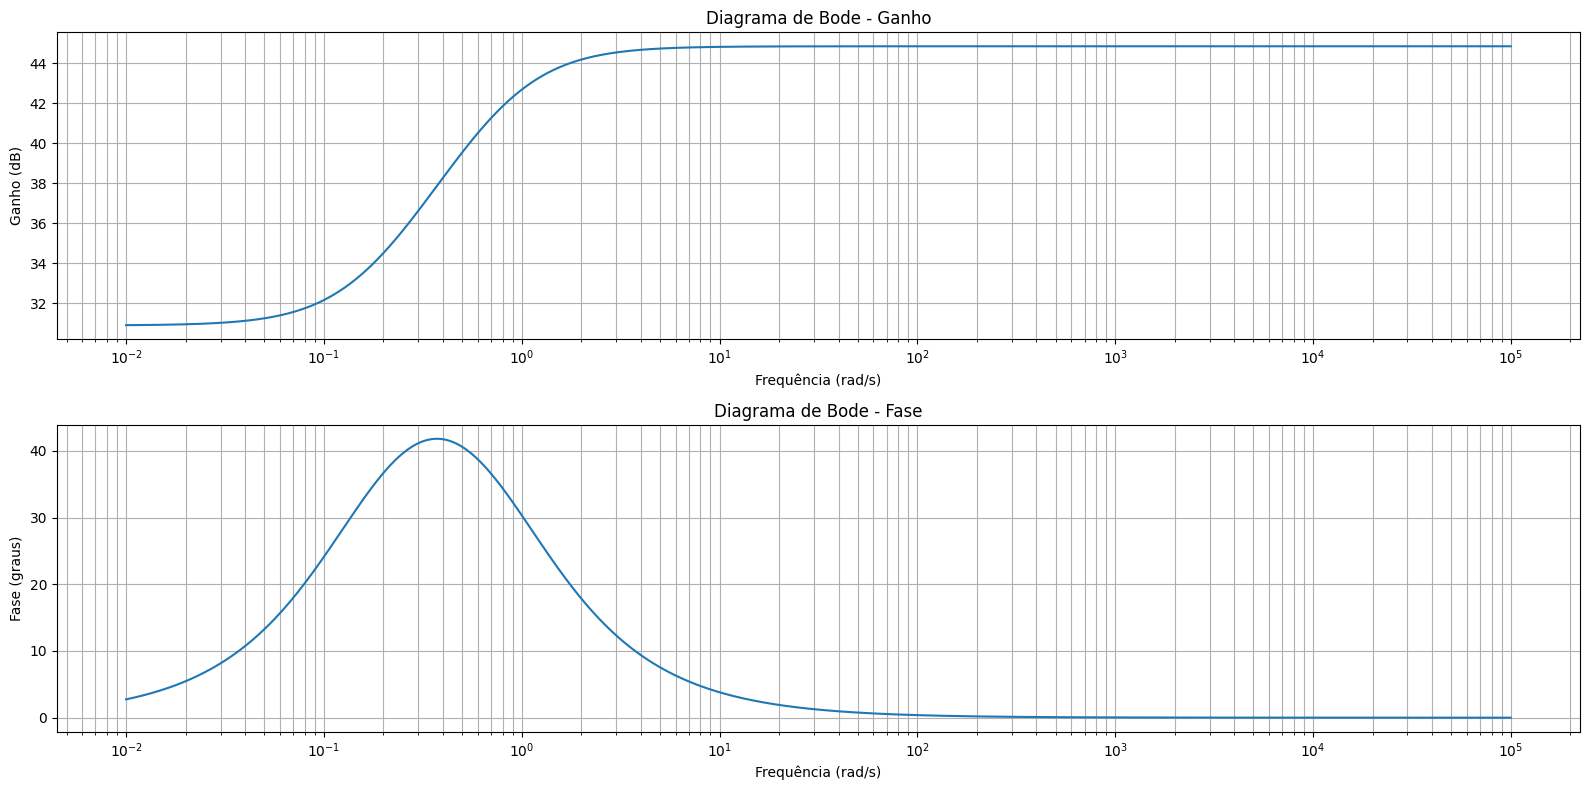

In [48]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

k_c = 35
T = 6
alpha = 0.2

# Função de transferência do controlador
num_compensador = [k_c*T, k_c*1]
den_compensador = [alpha*T, 1]
compensador = ct.TransferFunction(num_compensador, den_compensador)


# Frequências para o cálculo do Bode
omega = np.logspace(-2, 5, num=1000)

# Obter os dados do diagrama de Bode do controlador
mag_c, phase_c, omega_c = ct.bode_plot(compensador, omega, dB=True, Hz=False, plot=False)

# Configuração do tamanho da figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Plot do diagrama de ganho
ax1.semilogx(omega_c, 20*np.log10(mag_c))
ax1.set_xlabel('Frequência (rad/s)')
ax1.set_ylabel('Ganho (dB)')
ax1.set_title('Diagrama de Bode - Ganho')
ax1.grid(True, which='both')

# Plot do diagrama de fase
ax2.semilogx(omega_c, phase_c*(180/np.pi)+360)
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.set_title('Diagrama de Bode - Fase')
ax2.grid(True, which='both')

# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


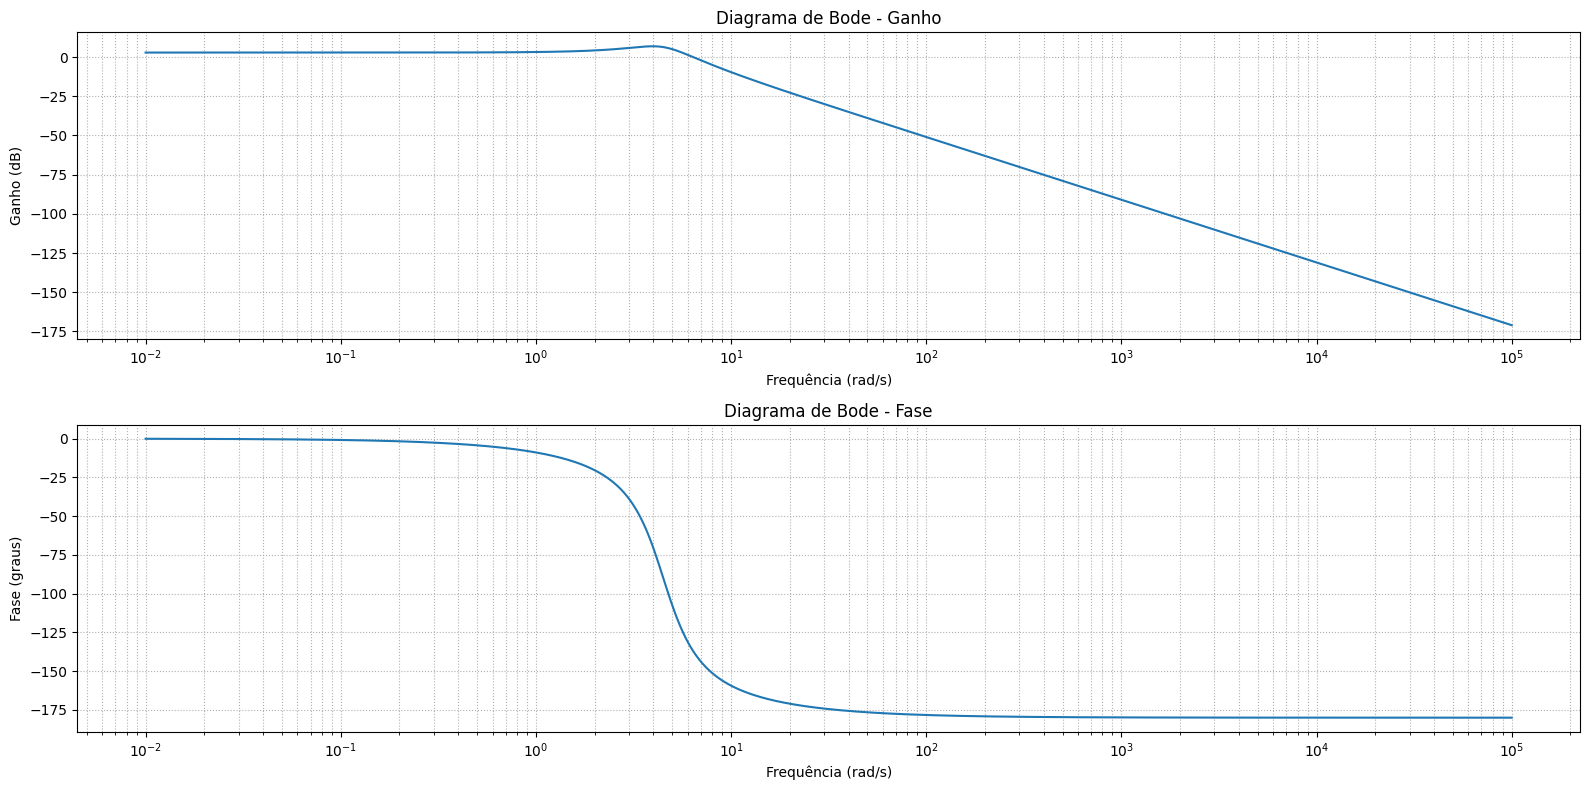

In [46]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do sistema
zeta = 0.3346
wn = 4.4971
k = 1.3885

# Função de transferência do sistema
num_sistema = [k*wn**2]
den_sistema = [1, 2*zeta*wn, wn**2]
sistema = ct.TransferFunction(num_sistema, den_sistema)

# Frequências para o cálculo do Bode
omega = np.logspace(-2, 5, num=1000)

# Obter os dados do diagrama de Bode do controlador
mag_s, phase_s, omega_s = ct.bode_plot(sistema, omega, dB=True, Hz=False, plot=False, deg=True)

# Configuração do tamanho da figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Plot do diagrama de ganho
ax1.semilogx(omega_s, 20*np.log10(mag_s))
ax1.set_xlabel('Frequência (rad/s)')
ax1.set_ylabel('Ganho (dB)')
ax1.set_title('Diagrama de Bode - Ganho')
ax1.grid(True, which='both', linestyle='dotted')

# Plot do diagrama de fase
ax2.semilogx(omega_s, phase_s*(180/np.pi))
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.set_title('Diagrama de Bode - Fase')
ax2.grid(True, which='both', linestyle='dotted')

# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


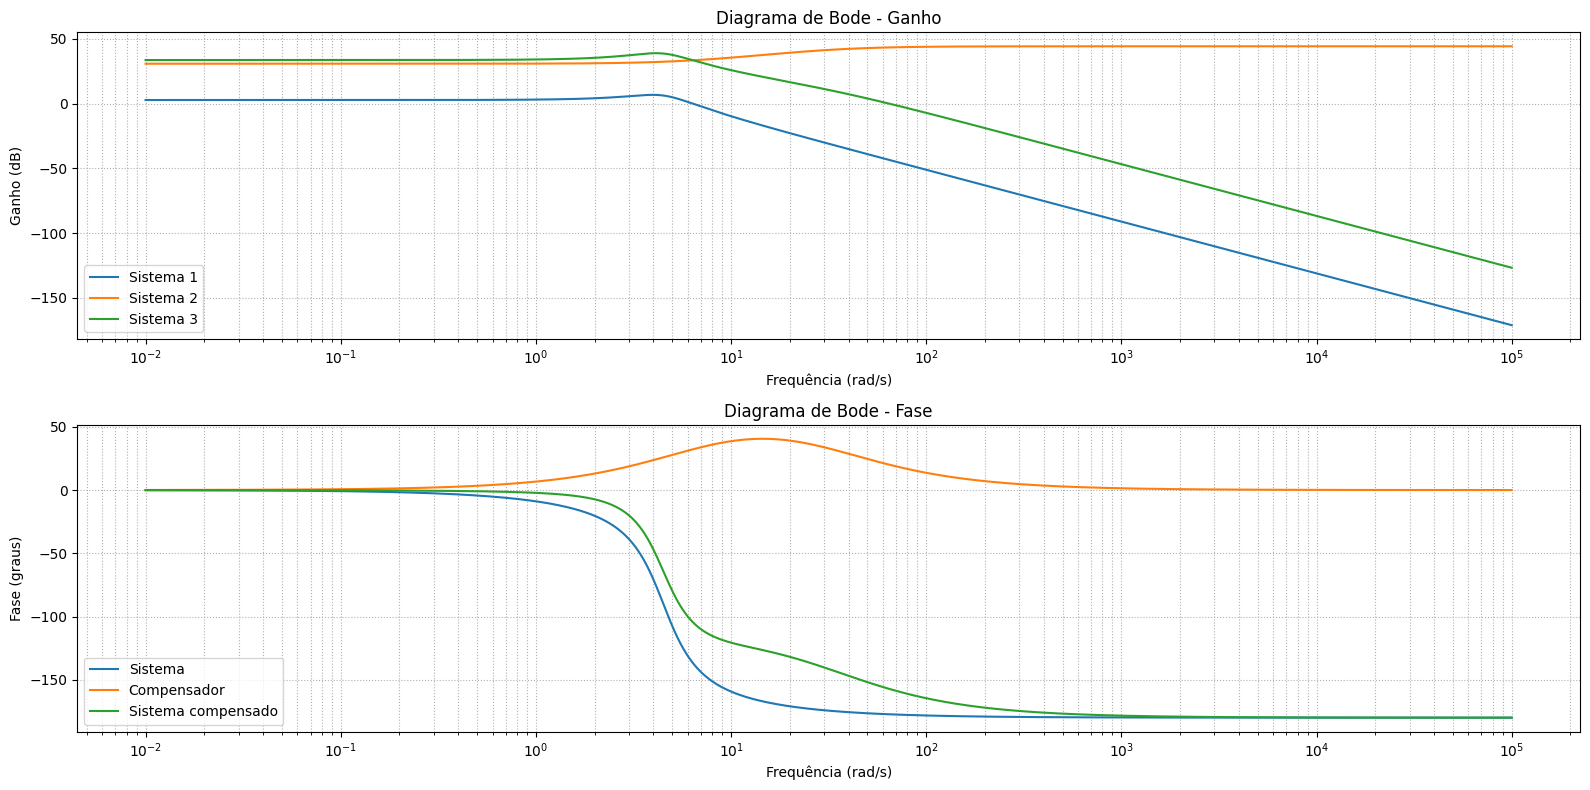

In [55]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Função de transferência do sistema
zeta = 0.3346
wn = 4.4971
k = 1.3885
num_sistema1 = [k*wn**2]
den_sistema1 = [1, 2*zeta*wn, wn**2]
sistema1 = ct.TransferFunction(num_sistema1, den_sistema1)

# Função de transferência do compensador
k_c = 35
T = 0.1498
alpha = 0.2119
num_compensador = [k_c*T, k_c*1]
den_compensador = [alpha*T, 1]
compensador = ct.TransferFunction(num_compensador, den_compensador)

# Função de transferência do sistema + compensador
sistema_compensado = sistema * compensador

# Frequências para o cálculo do Bode
omega = np.logspace(-2, 5, num=1000)

# Obter os dados do diagrama de Bode dos sistemas
mag_sistema1, phase_sistema1, omega_sistema1 = ct.bode(sistema1, omega, dB=True, Hz=False, plot=False)
mag_sistema2, phase_sistema2, omega_sistema2 = ct.bode(compensador, omega, dB=True, Hz=False, plot=False)
mag_sistema3, phase_sistema3, omega_sistema3 = ct.bode(sistema_compensado, omega, dB=True, Hz=False, plot=False)

# Configuração do tamanho da figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Plot do diagrama de ganho
ax1.semilogx(omega_sistema1, 20*np.log10(mag_sistema1), label='Sistema 1')
ax1.semilogx(omega_sistema2, 20*np.log10(mag_sistema2), label='Sistema 2')
ax1.semilogx(omega_sistema3, 20*np.log10(mag_sistema3), label='Sistema 3')
ax1.set_xlabel('Frequência (rad/s)')
ax1.set_ylabel('Ganho (dB)')
ax1.set_title('Diagrama de Bode - Ganho')
ax1.grid(True, which='both', linestyle='dotted')
ax1.legend()

# Plot do diagrama de fase
ax2.semilogx(omega_sistema1, phase_sistema1*(180/np.pi), label='Sistema')
ax2.semilogx(omega_sistema2, phase_sistema2*(180/np.pi)+360, label='Compensador')
ax2.semilogx(omega_sistema3, phase_sistema3*(180/np.pi), label='Sistema compensado')
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.set_title('Diagrama de Bode - Fase')
ax2.grid(True, which='both', linestyle='dotted')
ax2.legend()

# Ajuste de espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()


In [127]:
import sympy as sp

# Definir a variável simbólica 'w'
w_m = sp.symbols('w_m')

# Definir a equação
equacao = sp.sqrt((wn**2 - w_m**2) + (2*zeta*wn)**2) - k*wn**2 * mod_control_freq

# Resolver a equação
solucoes = sp.solve(equacao, w_m)

# Imprimir as soluções
for solucao in solucoes:
    print(f"Valor de w_m : {solucao}")

Valor de w: -754.533727727143
Valor de w: 754.533727727143


C:\Users\Mathe\AppData\Local\Temp\ipykernel_16924\3380608026.py:18: RuntimeWarning: invalid value encountered in log10
  plt.semilogx(omega, 20 * np.log10(mag))


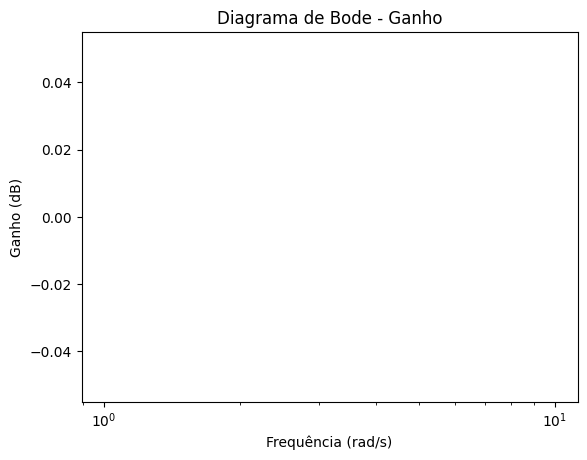

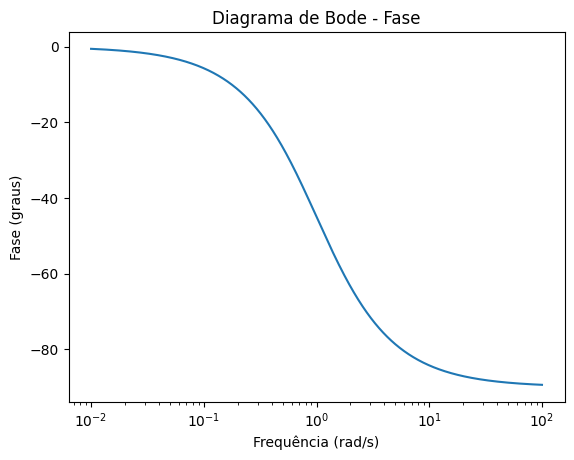

In [53]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Função de transferência do sistema
num = [1]  # Numerador da função de transferência
den = [1, 1]  # Denominador da função de transferência
sys = signal.TransferFunction(num, den)

# Frequências para o cálculo do Bode
omega = np.logspace(-2, 2, num=1000)

# Cálculo do diagrama de Bode
omega, mag, phase = signal.bode(sys, omega)

# Plot do diagrama de ganho
plt.figure()
plt.semilogx(omega, 20 * np.log10(mag))
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Ganho (dB)')
plt.title('Diagrama de Bode - Ganho')

# Plot do diagrama de fase
plt.figure()
plt.semilogx(omega, phase)
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Fase (graus)')
plt.title('Diagrama de Bode - Fase')

# Exibir os gráficos
plt.show()
